In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
%matplotlib inline
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>")) 

# Load Data

In [2]:
# Load index mapping 
with open('data/movie_to_idx.pkl', 'rb') as handle:
    movie2idx = pickle.load(handle)

#Load movies data
movies = pd.read_csv('data/movie_demographics.csv', index_col=0)

#load tags and ratings data
tags = pd.read_csv('data/ml-20m/tags.csv')

#Use ratings data to downsample tags data to only movies with ratings 
ratings = pd.read_csv('data/ml-20m/ratings.csv')
ratings = ratings.drop_duplicates('movieId')

#map movie index for tags data
tags = pd.merge(tags[['tag', 'movieId']], ratings, on="movieId", how="right")
tags.movieId = tags.movieId.apply(lambda x: movie2idx[x])

#create documents from tags
tags.fillna("", inplace=True)
tags = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "{%s}" % ' '.join(x)))
tags.reset_index(inplace=True)
movie_id = tags.movieId

# add genres to document
tags = pd.merge(movies, tags, left_index=True, right_on='movieId', how='right')
tags['document'] = tags[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
print(tags.shape)
tags.head(3)

(26744, 7)


,title,genres,ratings_count,avg_rating,movieId,tag,document
0,Jumanji (1995),Adventure|Children|Fantasy,22243,3.211977,0,{time travel adapted from:book board game chil...,{time travel adapted from:book board game chil...
1,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,8520,3.952230,1,{children Santa Claus dystopia abused children...,{children Santa Claus dystopia abused children...
2,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,44980,3.898055,2,{post-apocalyptic psychology time travel Brad ...,{post-apocalyptic psychology time travel Brad ...


In [3]:
tags.query('movieId == 131').document.values

array(["{adventure characters epic fantasy world fighting photography Action adventure atmospheric based on a book based on book beautifully filmed ensemble cast fantasy fantasy world high fantasy imdb top 250 magic music nature nothing at all Oscar (Best Cinematography) Oscar (Best Effects - Visual Effects) scenic stylized Tolkien wizards adventure atmospheric ensemble cast fantasy fantasy world magic stylized wizards Watched adapted from:book author:J. R. R. Tolkein based on book epic fantasy middle earth faithful to book fantasy good versus evil high fantasy joseph campbell's study of mythology influenced magic atmospheric boring high fantasy Action adventure atmospheric based on a book beautifully filmed fantasy high fantasy magic music mythology romance stylized time travel Viggo Mortensen wizards Peter Jackson Peter Jackson music must see Tolkien high fantasy Myth Tolkien wizards Ian McKellen bast background universe complex script joseph campbell's study of mythology influenced 

# TFIDF and SVD

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1, 1),
    min_df=0.00005,
    stop_words='english')
tfidf_matrix = tfidf.fit_transform(tags['document'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=tags.index.tolist())
print(tfidf_df.shape)
tfidf_df.head(3)

(26744, 12973)


,0,1,2,3,4,5,6,7,8,9,...,12963,12964,12965,12966,12967,12968,12969,12970,12971,12972
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
tfidf.vocabulary_

{'time': 11659,
 'travel': 11846,
 'adapted': 252,
 'book': 1407,
 'board': 1352,
 'game': 4498,
 'childhood': 2071,
 'recaptured': 9527,
 'herds': 5267,
 'cgi': 1954,
 'animals': 578,
 'scary': 10206,
 'fantasy': 3993,
 'robin': 9835,
 'williams': 12655,
 'joe': 6089,
 'johnston': 6104,
 'kid': 6359,
 'flick': 4231,
 'jungle': 6182,
 'lebbat': 6689,
 'adventure': 283,
 'children': 2073,
 'dynamic': 3463,
 'action': 234,
 'kirsten': 6406,
 'dunst': 3430,
 'childish': 2072,
 'filmed': 4151,
 'bc': 1082,
 'bad': 943,
 'based': 1045,
 'chris': 2121,
 'van': 12203,
 'allsburg': 434,
 'magic': 7144,
 'monkey': 7821,
 'saturn': 10165,
 'award': 898,
 'best': 1202,
 'special': 10918,
 'effects': 3549,
 'supporting': 11285,
 'actress': 241,
 'clv': 2276,
 'horrifying': 5464,
 'horror': 5467,
 'genre': 4606,
 'kids': 6365,
 'santa': 10126,
 'claus': 2206,
 'dystopia': 3472,
 'abused': 207,
 'surreal': 11300,
 'bleak': 1308,
 'dark': 2836,
 'visually': 12362,
 'appealing': 655,
 'atmospheric': 8

In [6]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=500)
latent_matrix = svd.fit_transform(tfidf_df)
print(latent_matrix.shape)

(26744, 500)


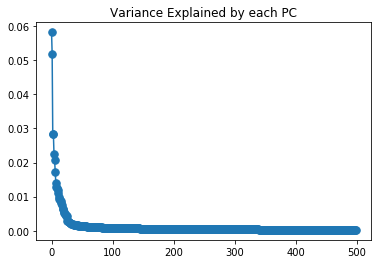

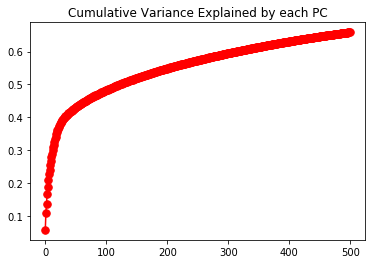

In [7]:
# plot var expalined to iuck number of latent dimensions to use
expl = svd.explained_variance_ratio_
plt.plot(expl, '.-', ms=15)
plt.title('Variance Explained by each PC');
plt.show()

plt.plot(np.cumsum(expl), '.-', ms=15, color='red')
plt.title('Cumulative Variance Explained by each PC');
plt.show()

In [10]:
n = 100 #number of latent dimensions to keep
latent_matrix_df = pd.DataFrame(latent_matrix[:,0:n], index=tags.index.tolist())
print(latent_matrix_df.shape)

(26744, 100)


In [14]:
latent_matrix_df.to_csv('data/svd_text_embeddings.csv', index=True, header=True)